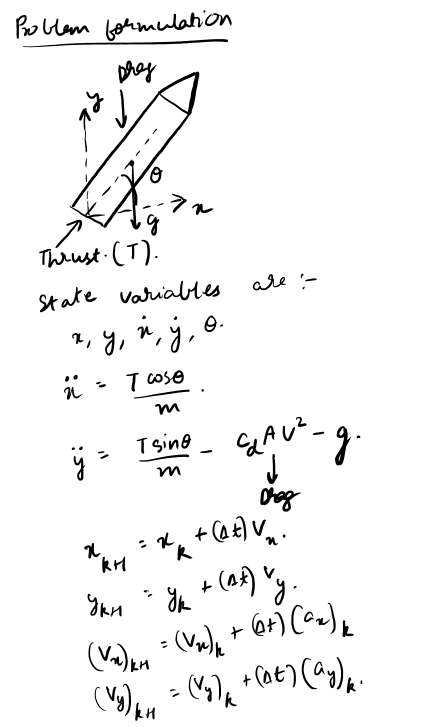

In [1]:
import logging
import math
import random
import numpy as np
import time
import torch as th
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# Defining the constants
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
BOOST_ACCEL = 0.18  # thrust constant
CD = 0.33 #drag coefficient

DENSITY = 0.3 # density of the medium
AREA = 10 # cros-sectional area

In [3]:
# Dynamics
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta
        action[2]: Drag 

        state[0] = x
        state[1] = y
        state[2] = Vx
        state[3] = Vy
        state[4] = theta
        state[5] = Drag in Y 
      
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = th.tensor([0., 0.,0, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Thrust for N initial state
        # N = len(state)
        sin_theta = th.sin(state[0,4])
        cos_theta = th.cos(state[0,4])
        
        state_tensor = th.tensor([-0.5*(FRAME_TIME**2)*sin_theta,
                                   0.5*(FRAME_TIME**2)*cos_theta,
                                  -FRAME_TIME * sin_theta,
                                  FRAME_TIME * cos_theta,
                                  0.])
                                 
        delta_state = BOOST_ACCEL * th.mul(state_tensor, action[0,0])

        # Theta
        delta_state_theta = th.mul(th.tensor([0., 0., 0., 0, 1.]),(action[0, 1])) 

        #for drag
        Vy = th.matmul(state,th.tensor([0., 0., 0., 1., 0.]))
        # Vx = th.matmul(state,th.tensor([0., 1., 0., 0., 0.]))

        # Defining the drag w.r.t the total velocity
        drag = - CD * AREA * DENSITY * 0.5 * (Vy ** 2)

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag 

        # Update state
        step_mat = th.tensor([[1., 0., FRAME_TIME, 0., 0.],
                              [0., 1., 0., FRAME_TIME, 0.],   
                              [0., 0., 1., 0., 0.],
                              [0., 0., 0., 1., 0],
                              [0., 0., 0., 0., 1.]])
        

        state = th.matmul(step_mat, state.T)
        return (state.T)

In [4]:
# Controller
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

In [17]:
# Simulation
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = th.empty((1, 0))
        self.u_trajectory = th.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[np.random.random(),1.,0.,0.,0.]] 
        return th.tensor(state, requires_grad=False).float()

    def error(self, state):
        weight_vector = th.tensor([1.,1.,5.,5.,20.])
        return th.matmul(th.square(state),th.transpose(weight_vector,-1,0))

In [18]:
# Optimization
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        loss_list = np.zeros( epochs)
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            loss_list[epoch]=loss
            
        plt.plot(list(range(epochs)), loss_list)
            
        plt.title('Loss function')
        plt.xlabel('Iterations')
        plt.ylabel('Error')

        plt.show()
          
        self.visualize()

        
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2] 
        vy = data[:, 3]
        theta = data[:, 4]
        plt.plot(np.linspace(0., 1.0, num=100),x)
        plt.xlabel('time')
        plt.ylabel('X')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),y)
        plt.xlabel('time') 
        plt.ylabel('Y')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),vx)
        plt.xlabel('time')
        plt.ylabel('Vel_X')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),vy)
        plt.xlabel("time")
        plt.ylabel('Vel_Y')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),theta)
        plt.xlabel("time")
        plt.ylabel('theta')
        plt.show()

[1] loss: 5.421
[2] loss: 3.898
[3] loss: 2.913
[4] loss: 2.258
[5] loss: 1.816
[6] loss: 1.517
[7] loss: 1.315
[8] loss: 1.179
[9] loss: 1.088
[10] loss: 1.028
[11] loss: 0.988
[12] loss: 0.963
[13] loss: 0.947
[14] loss: 0.936
[15] loss: 0.930
[16] loss: 0.926
[17] loss: 0.924
[18] loss: 0.923
[19] loss: 0.922
[20] loss: 0.922
[21] loss: 0.922
[22] loss: 0.922
[23] loss: 0.922
[24] loss: 0.923
[25] loss: 0.923
[26] loss: 0.923
[27] loss: 0.923
[28] loss: 0.923
[29] loss: 0.923
[30] loss: 0.923
[31] loss: 0.924
[32] loss: 0.924
[33] loss: 0.924
[34] loss: 0.924
[35] loss: 0.924
[36] loss: 0.924
[37] loss: 0.924
[38] loss: 0.924
[39] loss: 0.924
[40] loss: 0.924


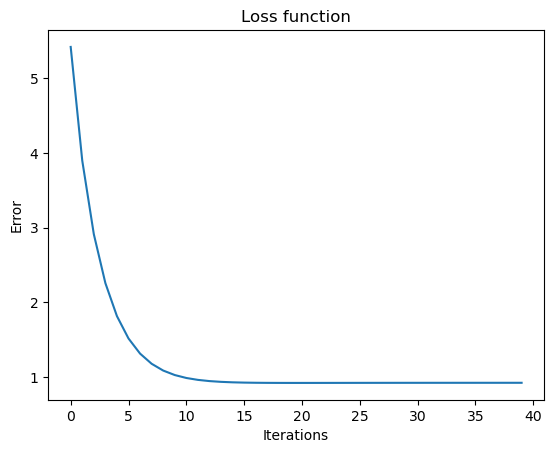

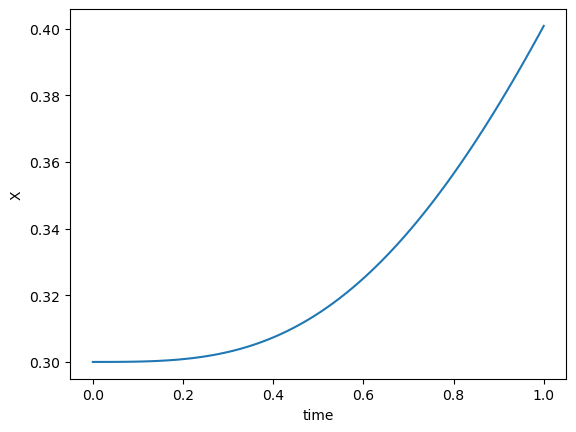

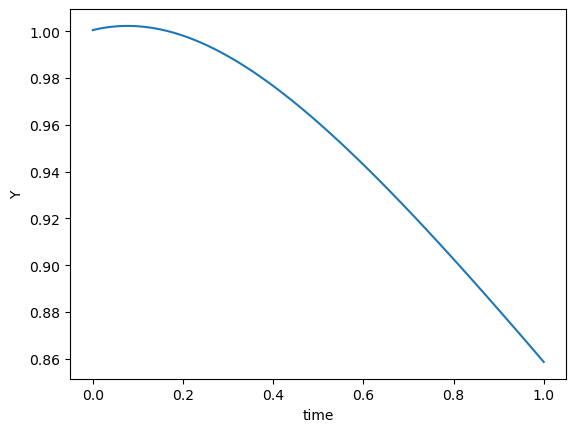

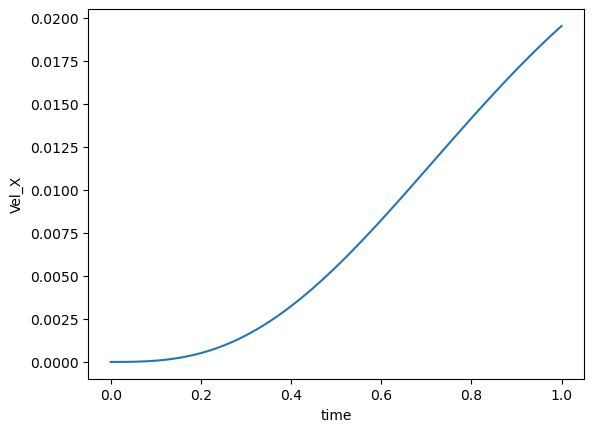

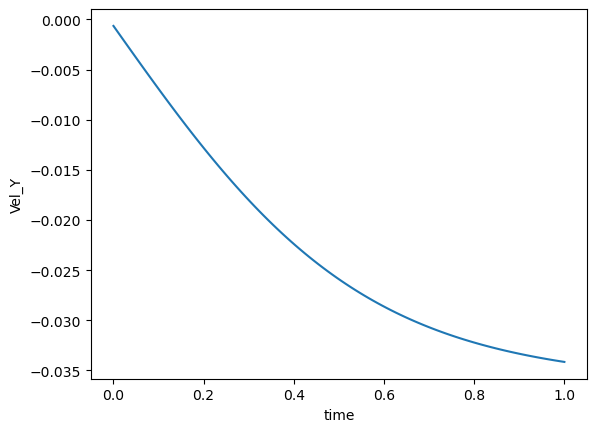

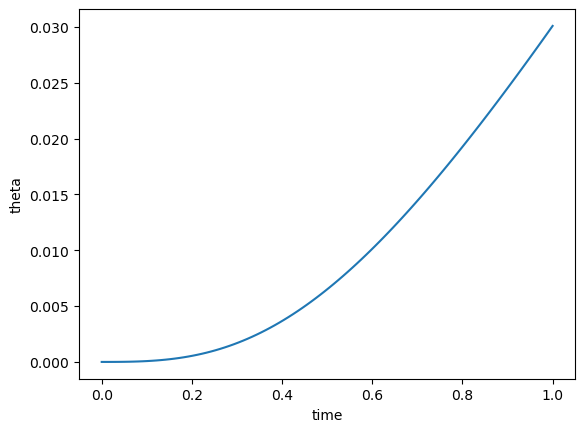

In [19]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(40)  # training with number of epoch

As we can see, the loss function converges towards a final value of 0.924. For a better formulation, we can consider constraints in state and action spaces or gimballing of thrust. Also the weight vector can be modified and the effect of its change on the result can be studied further.